In [1]:
import pandas as pd
import os.path as op
import numpy as np
from tms_risk.utils import get_all_behavior, get_subjects
from tqdm.contrib.itertools import product
import matplotlib.pyplot as plt
import pingouin
import seaborn as sns

palette = ['gray'] + sns.color_palette()[2:4]

In [2]:
def get_pdf(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    if n_voxels == 1:
        key = 'decoded_pdfs.volume.cv_voxel_selection'
    else:
        key = 'decoded_pdfs.volume'

    subject = f'{subject:02d}'

    if denoise:
        key += '.denoise'

    if smoothed:
        key += '.smoothed'

    if pca_confounds and not denoise:
        key += '.pca_confounds'

    if natural_space:
        key += '.natural_space'

    if n_voxels == 1:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_space-T1w_pars.tsv')
    else:
        pdf = op.join(bids_folder, 'derivatives', key, f'sub-{subject}', 'func', f'sub-{subject}_ses-{session}_mask-{mask}_nvoxels-{n_voxels}_space-T1w_pars.tsv')

    if op.exists(pdf):
        pdf = pd.read_csv(pdf, sep='\t', index_col=[0,1])
        pdf.columns = pdf.columns.astype(float)

        if natural_space:
            pdf = pdf.loc[:, 5:112]
        else:
            pdf = pdf.loc[:, np.log(5):np.log(112)]
    else:
        print(pdf)
        pdf = pd.DataFrame(np.zeros((0, 0)))
    
    pdf /= np.trapz(pdf, pdf.columns, axis=1)[:, np.newaxis]

    return pdf

def get_decoding_info(subject, session, pca_confounds=False, denoise=False, smoothed=False, bids_folder='/data/ds-tmsrisk', mask='NPC12r', n_voxels=100, natural_space=False):

    pdf = get_pdf(subject, session, pca_confounds=pca_confounds, denoise=denoise, smoothed=smoothed, bids_folder=bids_folder, mask=mask, n_voxels=n_voxels, natural_space=natural_space)

    E = pd.Series(np.trapz(pdf*pdf.columns.values[np.newaxis,:], pdf.columns, axis=1), index=pdf.index)

    E = pd.concat((E,), keys=[(int(subject), int(session), 'pca_confounds' if pca_confounds else 'no pca', 'GLMstim' if denoise else "glm", 'smoothed' if smoothed else 'not smoothed', mask, n_voxels,
                                'natural' if natural_space else 'log')],
    names=['subject', 'session', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'space']).to_frame('E')

    
    E['sd'] = np.trapz(np.abs(E.values - pdf.columns.astype(float).values[np.newaxis, :]) * pdf, pdf.columns, axis=1)

    return E

In [3]:
subjects = [int(sub.subject) for sub in get_subjects(all_tms_conditions=True, exclude_outliers=True)]
sessions = [1, 2, 3]
pca_confounds = [False]
denoise = [True]
smoothed = [False]
masks = ['NPCr1cm-surface', 'NPCr1cm-cluster', 'NPCr2cm-surface', 'NPCr2cm-cluster']
n_voxels = [0, 1, 100]
natural_space = [True]


pred = []
pdfs = []
for (sub, session, pcac, den, smooth, mask, nv, ns) in product(subjects, sessions, pca_confounds, denoise, smoothed, masks, n_voxels, natural_space):

    if not ((session == 1) & (nv == 0)):
        pdfs.append(get_pdf(sub, session, pcac, den, smooth, '/data/ds-tmsrisk/', mask, nv, ns))
        pred.append(get_decoding_info(sub, session, pcac, den, smooth, '/data/ds-tmsrisk', mask, nv, ns))

  0%|          | 0/1260 [00:00<?, ?it/s]

/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-cluster_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-1_mask-NPCr1cm-cluster_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-2_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.denoise.natural_space/sub-02/func/sub-02_ses-2_mask-NPCr1cm-surface_space-T1w_pars.tsv
/data/ds-tmsrisk/derivatives/decoded_pdfs.volume.cv_voxel_selection.de

In [4]:
pred = pd.concat(pred)
pdf = pd.concat(pdfs)
df = get_all_behavior(drop_no_responses=False)
pred = pred.join(df, how='inner')
r1 = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2_ = pred.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels', 'run']).apply(lambda d: pingouin.corr(d['E'], d['n1']))
r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')
/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:56: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return pd.concat(behavior)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_69208/884262180.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r2 = r2_.groupby(['subject', 'session', 'stimulation_condition', 'pca', 'glm', 'smoothed', 'mask', 'n_voxels']).mean()


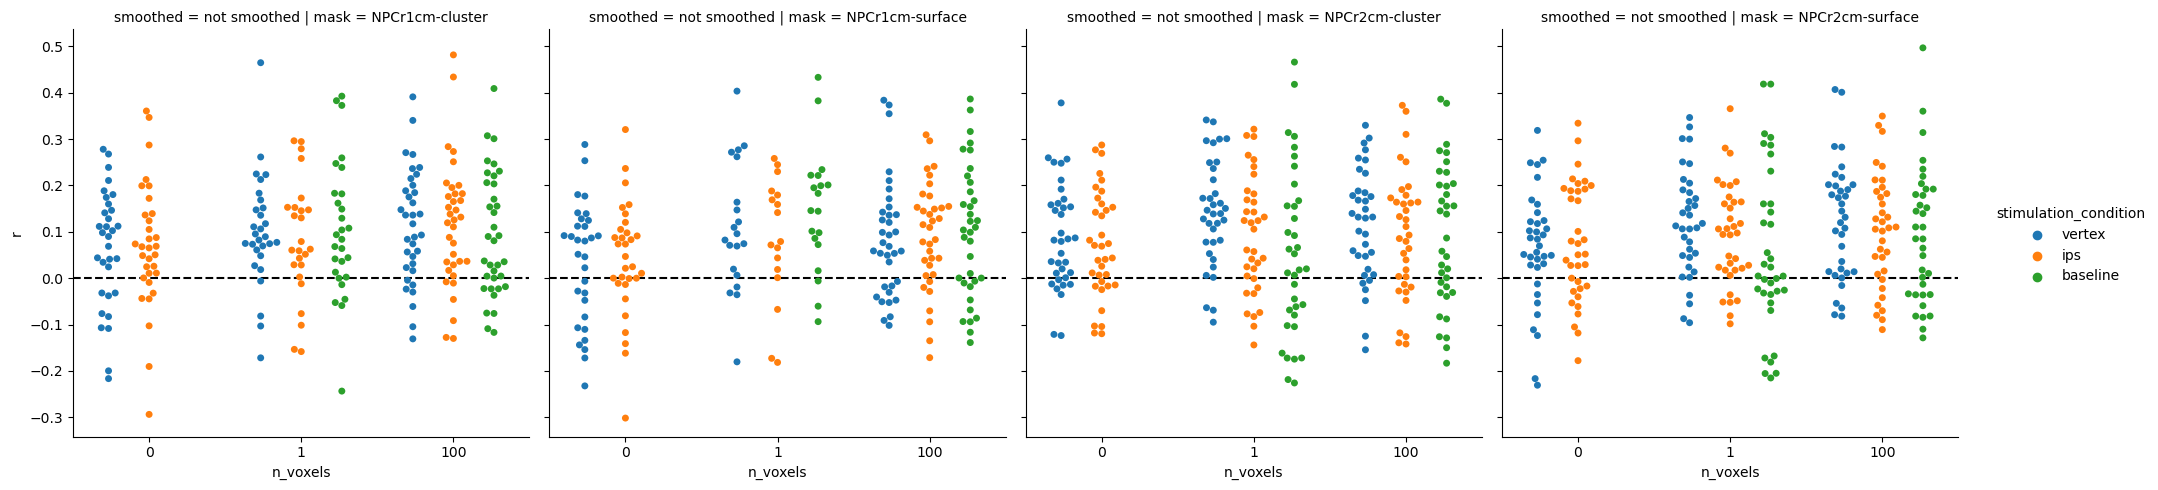

In [5]:
g = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='swarm', row='smoothed', dodge=True, ci=67)
g.map(lambda *args, **kwargs: plt.axhline(0, c='k', ls='--'))

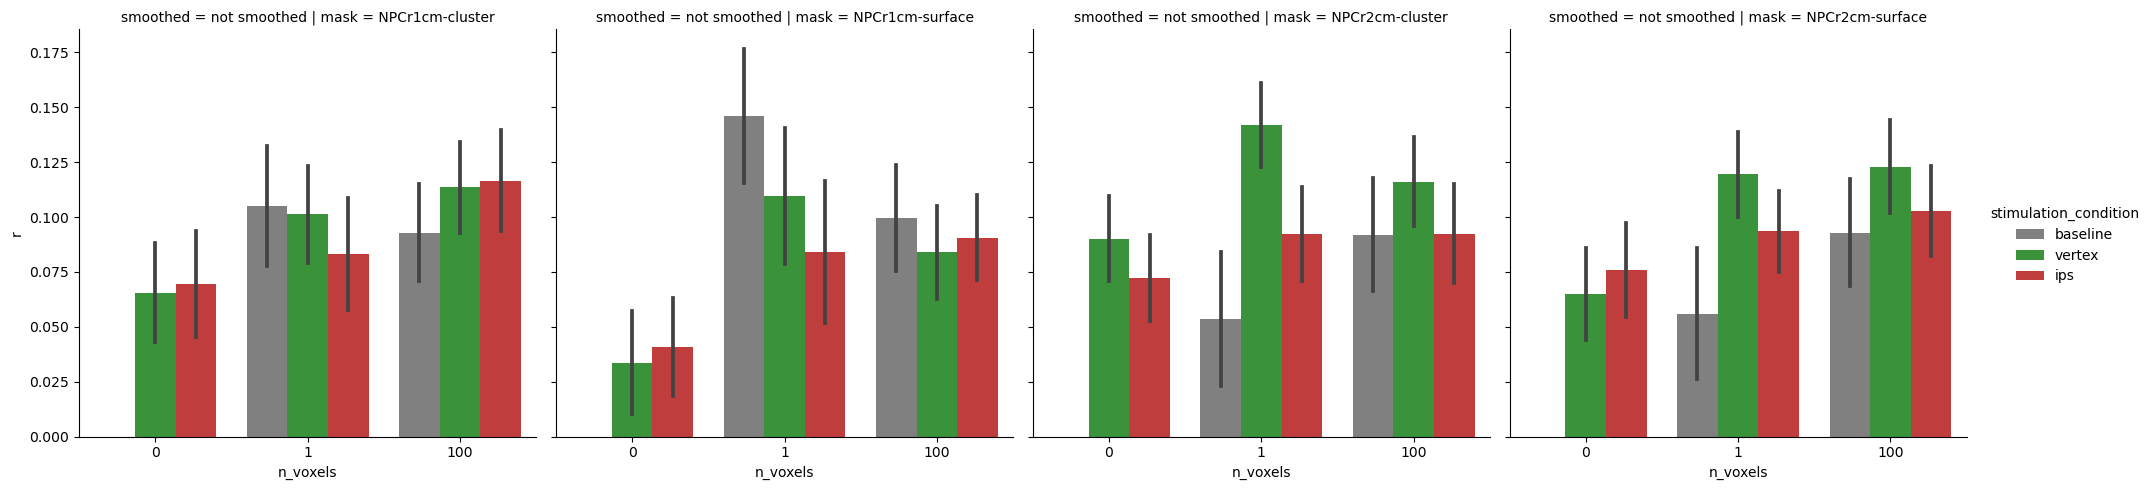

In [6]:
fac = sns.catplot(x='n_voxels', y='r', hue='stimulation_condition',data=r2.reset_index(), col='mask', kind='bar', row='smoothed', dodge=True, errorbar='se',
                  palette=palette)

In [7]:
tmp = r2.drop('baseline', level='stimulation_condition')

tmp.groupby(['mask', 'n_voxels']).apply(lambda d: pingouin.rm_anova(d.reset_index(), dv='r', within=['stimulation_condition'], subject='subject'))

Source  ddof1  ddof2         F  \
mask            n_voxels                                                    
NPCr1cm-cluster 0        0  stimulation_condition      1     31  0.032633   
                1        0  stimulation_condition      1     22  1.586543   
                100      0  stimulation_condition      1     34  0.014595   
NPCr1cm-surface 0        0  stimulation_condition      1     30  0.076225   
                1        0  stimulation_condition      1     12  1.078285   
                100      0  stimulation_condition      1     34  0.061745   
NPCr2cm-cluster 0        0  stimulation_condition      1     34  1.343136   
                1        0  stimulation_condition      1     34  4.992127   
                100      0  stimulation_condition      1     34  0.930431   
NPCr2cm-surface 0        0  stimulation_condition      1     34  0.265313   
                1        0  stimulation_condition      1     34  1.319113   
                100      0  stimulation_condition      1     34  0.655354   

                               p-unc       ng2  eps  
mask            n_voxels                             
NPCr1cm-cluster 0        0  0.857822  0.000232  1.0  
                1        0  0.221020  0.031216  1.0  
                100      0  0.904553  0.000156  1.0  
NPCr1cm-surface 0        0  0.784373  0.000798  1.0  
                1        0  0.319553  0.027735  1.0  
                100      0  0.805254  0.000780  1.0  
NPCr2cm-cluster 0        0  0.254557  0.006280  1.0  
                1        0  0.032145  0.041880  1.0  
                100      0  0.341562  0.008747  1.0  
NPCr2cm-surface 0        0  0.609826  0.002018  1.0  
                1        0  0.258768  0.013628  1.0  
                100      0  0.423834  0.006794  1.0